In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import packages
from keras.layers import Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
# visualization
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

def myscatter(Y, class_idxs, legend=False, ran=True, seed=229):
    if ran:
        np.random.seed(seed)
    Y = np.array(Y)
    fig, ax = plt.subplots(figsize=(6,4), dpi=300)
    classes = list(np.unique(class_idxs))
    markers = 'osD' * len(classes)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if ran:
        np.random.shuffle(colors)

    for i, cls in enumerate(classes):
        mark = markers[i]
        ax.plot(Y[class_idxs == cls, 0], Y[class_idxs == cls, 1], marker=mark,
                linestyle='', ms=4, label=str(cls), alpha=1, color=colors[i],
                markeredgecolor='black', markeredgewidth=0.15)
    if legend:
        ax.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0, fontsize=10, markerscale=2, frameon=False,
                  ncol=2, handletextpad=0.1, columnspacing=0.5)

    plt.xticks([])
    plt.yticks([])

    return ax

In [4]:
# t-SNE
def tsne(X, dim=2, ran=23):
    t_sne = TSNE(n_components=dim, random_state=ran)
    Y_tsne = t_sne.fit_transform(X)
    return Y_tsne

In [ ]:
!pip install phenograph

In [ ]:
!pip install scanpy

In [7]:
# clustering layer

from tensorflow.keras import activations, constraints, initializers, regularizers
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow.keras.backend as K
import phenograph
from sklearn.cluster import KMeans

class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters', trainable=True)
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def target_distribution(q):
    q = q.numpy()
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

def computeCentroids(data, labels):
    n_clusters = len(np.unique(labels))
    return np.array([data[labels == i].mean(0) for i in range(n_clusters)])

def get_centers(H, mode="kmeans", n_cluster=10):
    if mode == "louvain":
        l, _,  _ = phenograph.cluster(H)
    elif mode == "kmeans":
        l = KMeans(n_clusters=n_cluster, random_state=0).fit(h).labels_
    centers = computeCentroids(H, l)
    return centers, l

In [96]:
cells_number = np.array(pd.read_csv("/content/drive/My Drive/compbio/test_data/aml328/AML328_idents.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("/content/drive/My Drive/compbio/test_data/aml328/AML328_all_data.csv", index_col=0, sep="\t"))

In [97]:
cells_number = cells_number.flatten()

In [98]:
count.shape

(6405, 20862)

In [99]:
len(cells_number)

6405

In [100]:
# extract 8 cell types of interest
count1 = count[cells_number == "lateEry", :]
count2 = count[cells_number == "T", :]
count3 = count[cells_number == "B", :]
count4 = count[cells_number == "Mono", :]
count5 = count[cells_number == "NK", :]
count6 = count[cells_number == "Plasma", :]
count7 = count[cells_number == "GMP", :]
count8 = count[cells_number == "Prog", :]

In [101]:
cells1 = cells_number[cells_number == "lateEry"]
cells2 = cells_number[cells_number == "T"]
cells3 = cells_number[cells_number == "B"]
cells4 = cells_number[cells_number == "Mono"]
cells5 = cells_number[cells_number == "NK"]
cells6 = cells_number[cells_number == "Plasma"]
cells7 = cells_number[cells_number == "GMP"]
cells8 = cells_number[cells_number == "Prog"]

In [102]:
count = np.concatenate([count1,count2,count3,count4,count5,count6,count7,count8],axis=0)
cells_number = np.concatenate([cells1,cells2,cells3,cells4,cells5,cells6,cells7,cells8],axis=0)

In [103]:
np.unique(cells_number)

array(['B', 'GMP', 'Mono', 'NK', 'Plasma', 'Prog', 'T', 'lateEry'],
      dtype=object)

In [104]:
count.shape

(5222, 20862)

In [105]:
import scanpy as sc
import anndata as ad

In [106]:
# data normalization
adata = ad.AnnData(count, dtype='float32')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw=adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)
adata = adata[:, adata.var['highly_variable']]

In [107]:
count = adata.X

In [108]:
count.shape

(5222, 3694)

In [109]:
# optional
# run the model on half of the data
se = np.arange(0,5222,2)
count = count[se,]
cells_number = cells_number[se]

In [110]:
# preprocessing
[n_sample, n_gene] = count.shape

x_train = count.astype('float32')
cells_number=cells_number.flatten()

In [111]:
from keras.models import Sequential
from tensorflow.keras.losses import MSE, KLD
from keras.constraints import NonNeg
class AE(tf.keras.Model):

    def __init__(self, X, n_gene, hidden_dim=[], latent_dim=50, impute_dim=64):
        super(AE, self).__init__()
        self.X = X
        self.latent_dim = latent_dim
        self.n_gene = n_gene

        # encoder

        #encoder_in = Input(shape=n_gene)
        #encoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(encoder_in)
        #encoded2 = Dense(latent_dim, activation = "relu", use_bias=True)(encoded1)
        #kernel_constraint=NonNeg(),
        #kernel_initializer='glorot_uniform'

        encoder_in = Input(shape=n_gene)
        if len(hidden_dim) == 0:
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoder_in)
        elif len(hidden_dim) == 1:
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded)
        elif len(hidden_dim) == 2:
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded = Dense(hidden_dim[1], activation = "relu", use_bias=True)(encoded)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded)
        else:
            encoded_list = []
            encoded = Dense(hidden_dim[0], activation = "relu", use_bias=True)(encoder_in)
            encoded_list.append(encoded)
            for i in range(1, len(hidden_dim)-1):
                encoded = Dense(hidden_dim[i], activation = "relu", use_bias=True)(encoded_list[i-1])
                encoded_list.append(encoded)
            encoded = Dense(latent_dim, activation = "relu", use_bias=True)(encoded_list[-1])
        encoder = Model(inputs=encoder_in, outputs=encoded, name="encoder")

        self.encoder = encoder

        # decoder

        #decoder_in = Input(shape=latent_dim)
        #decoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(decoder_in)
        #decoded2 = Dense(n_gene, activation = "relu", use_bias=True)(decoded1)
        #decoder = Model(inputs=decoder_in, outputs=decoded2, name="decoder")

        hidden_rev = hidden_dim[::-1]
        decoder_in = Input(shape=latent_dim)
        if len(hidden_dim) == 0:
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoder_in)
        elif len(hidden_dim) == 1:
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded)
        elif len(hidden_dim) == 2:
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded = Dense(hidden_rev[1], activation = "relu", use_bias=True)(decoded)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded)
        else:
            decoded_list = []
            decoded = Dense(hidden_rev[0], activation = "relu", use_bias=True)(decoder_in)
            decoded_list.append(decoded)
            for i in range(1, len(hidden_rev)-1):
                decoded = Dense(hidden_rev[i], activation = "relu", use_bias=True)(decoded)
                decoded_list.append(decoded)
            decoded = Dense(n_gene, activation = "relu", use_bias=True)(decoded_list[-1])
        decoder = Model(inputs=decoder_in, outputs=decoded, name="decoder")

        self.decoder = decoder

        # imputer
        impute_in = Input(shape=n_gene)
        imputed1 = Dense(impute_dim, activation = "relu")(impute_in)
        imputed2 = Dense(n_gene, activation = "relu")(imputed1)
        imputer = Model(inputs=impute_in, outputs=imputed2, name="imputer")

        impute_mask = np.zeros([n_sample, n_gene])
        for i in range(n_sample):
            for j in range(n_gene):
                if count[i,j] == 0:
                    impute_mask[i,j] = 1
        self.mask = tf.convert_to_tensor(impute_mask, dtype=tf.float32)

        self.imputer = imputer

        self.autoencoder = Sequential([encoder, decoder, imputer])

    # pre-training
    def train(self, T=2, max_epoch=100, learning_rate=0.0001):
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        loss0 = 0
        counter = 0
        for epoch in range(1, max_epoch+1):
            with tf.GradientTape(persistent=True) as tape:

                x = self.X
                loss = 0

                for t in range(T):
                    h = self.encoder(x)
                    y = self.decoder(h)

                    v = self.imputer(y)
                    x = self.X + tf.multiply(self.mask, v)

                    loss += tf.reduce_mean(MSE(self.X, y))

                if abs(loss - loss0) < 0.0005:
                    counter += 1
                else:
                    counter = 0
                if counter >= 10:
                    break;

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            loss0 = loss
            if epoch % 5 == 0:
                print(loss)
        print("Finish!")

    # clustering training
    def clustering_train(self, centers, h, wc=2.5, max_epoch=30, learning_rate=0.0001):

        centers, labels = get_centers(np.array(h), mode="louvain", n_cluster=8)
        k = len(np.unique(labels))

        clustering_layer = ClusteringLayer(n_clusters=k, name='clustering', input_shape=(self.latent_dim,))
        self.clustering = keras.models.Sequential([clustering_layer])

        self.clustering.set_weights([centers])

        q = self.clustering(h)
        p = target_distribution(q)

        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        for epoch in range(1, max_epoch+1):
            if epoch % 10 == 0:
                q = self.clustering(h)
                p = target_distribution(q)
            with tf.GradientTape(persistent=True) as tape:

                h = self.encoder(self.X)
                y = self.decoder(h)

                loss = tf.reduce_mean(MSE(self.X, y))

                q_out = self.clustering(h)

                cluster_loss = tf.reduce_mean(KLD(p, q_out))
                loss += wc * cluster_loss

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if epoch % 10 == 0:
                print(loss)
                print(cluster_loss)
                #print(self.clustering.get_layer(name='clustering').clusters)
        print("Finish!")

In [112]:
autoencoder = AE(x_train, n_gene, hidden_dim=[512, 64], latent_dim=32, impute_dim=64)

In [113]:
autoencoder.train(T=2, max_epoch=100)

tf.Tensor(0.28708395, shape=(), dtype=float32)
tf.Tensor(0.27771106, shape=(), dtype=float32)
tf.Tensor(0.27199006, shape=(), dtype=float32)
tf.Tensor(0.2658734, shape=(), dtype=float32)
tf.Tensor(0.26116484, shape=(), dtype=float32)
tf.Tensor(0.25668395, shape=(), dtype=float32)
tf.Tensor(0.25326324, shape=(), dtype=float32)
tf.Tensor(0.25122845, shape=(), dtype=float32)
Finish!


In [114]:
h = autoencoder.encoder(x_train)

In [115]:
ed = tsne(h)  #Y

<Axes: >

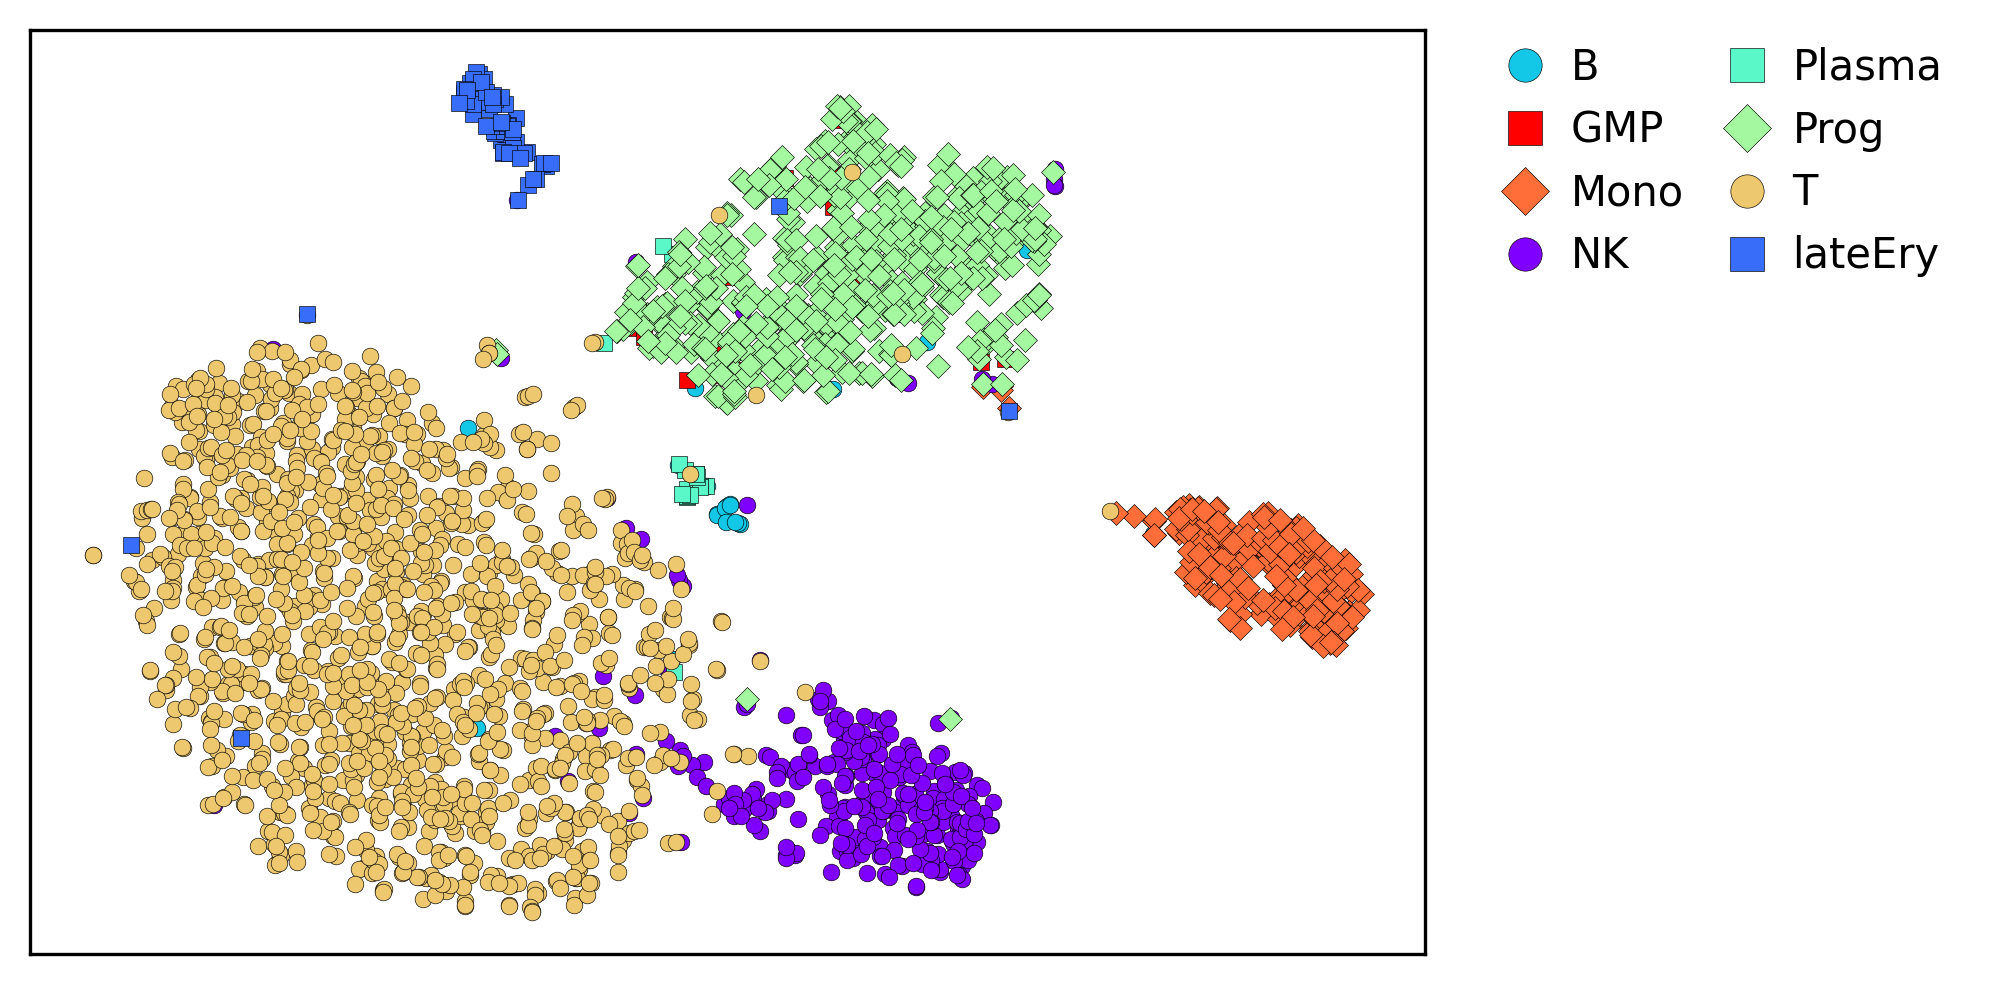

In [116]:
myscatter(ed, cells_number, legend=True)

In [117]:
import os
os.chdir("/content/drive/My Drive/compbio/")

In [62]:
autoencoder.autoencoder.save_weights('AML328_weights_test.h5')

In [79]:
autoencoder.autoencoder.load_weights('AML328_weights_test.h5')

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.09976387023925781 seconds


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Jaccard graph constructed in 1.2625737190246582 seconds
Wrote graph to binary file in 0.05976128578186035 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.765986
After 7 runs, maximum modularity is Q = 0.768843
Louvain completed 27 runs in 6.172295808792114 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.846298694610596 seconds


<Axes: >

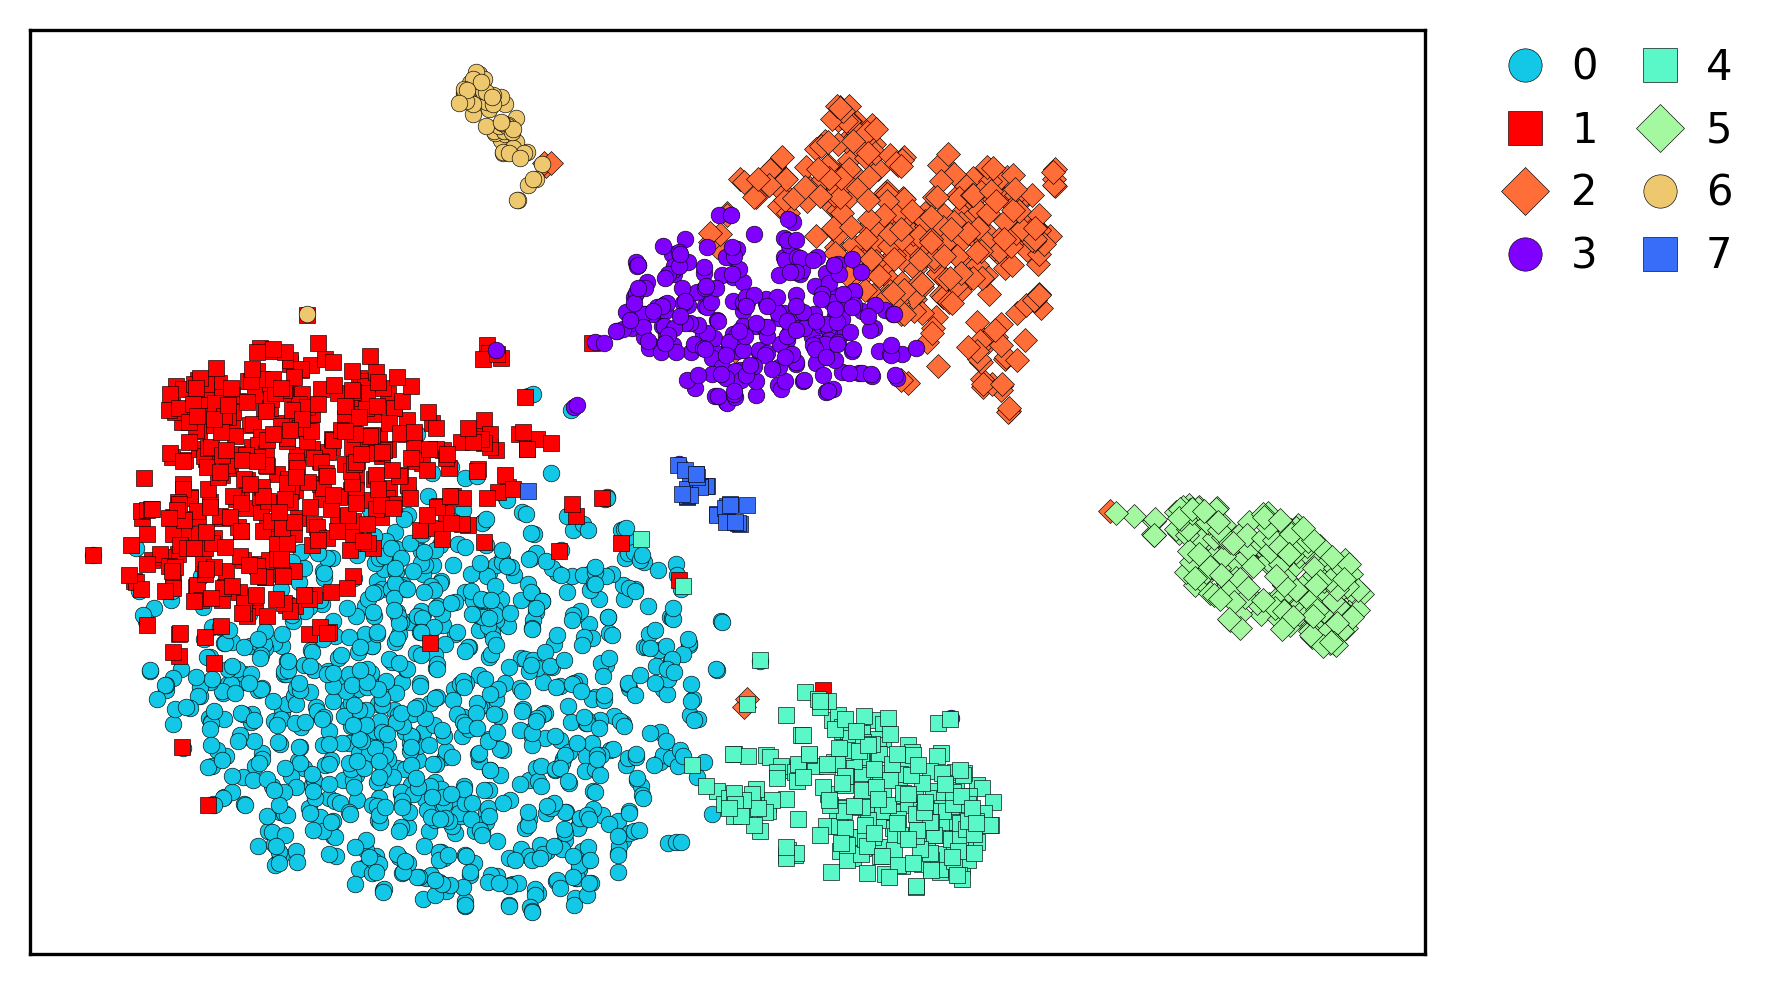

In [118]:
centers, labels = get_centers(np.array(h), mode="louvain", n_cluster=8)
myscatter(ed, labels, legend=True)

In [119]:
centers = computeCentroids(np.array(h), labels)

In [120]:
autoencoder.clustering_train(centers, h, wc=5, max_epoch=20)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.16569256782531738 seconds


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Jaccard graph constructed in 1.214608907699585 seconds
Wrote graph to binary file in 0.06557917594909668 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.762544
After 3 runs, maximum modularity is Q = 0.764928
After 6 runs, maximum modularity is Q = 0.766996
After 11 runs, maximum modularity is Q = 0.768307
Louvain completed 31 runs in 7.577694416046143 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 9.413418531417847 seconds


tf.Tensor(0.9980041, shape=(), dtype=float32)
tf.Tensor(0.1745646, shape=(), dtype=float32)
tf.Tensor(0.95629334, shape=(), dtype=float32)
tf.Tensor(0.16622442, shape=(), dtype=float32)
Finish!


In [121]:
h = autoencoder.encoder(x_train)

In [122]:
ed = tsne(h)

<Axes: >

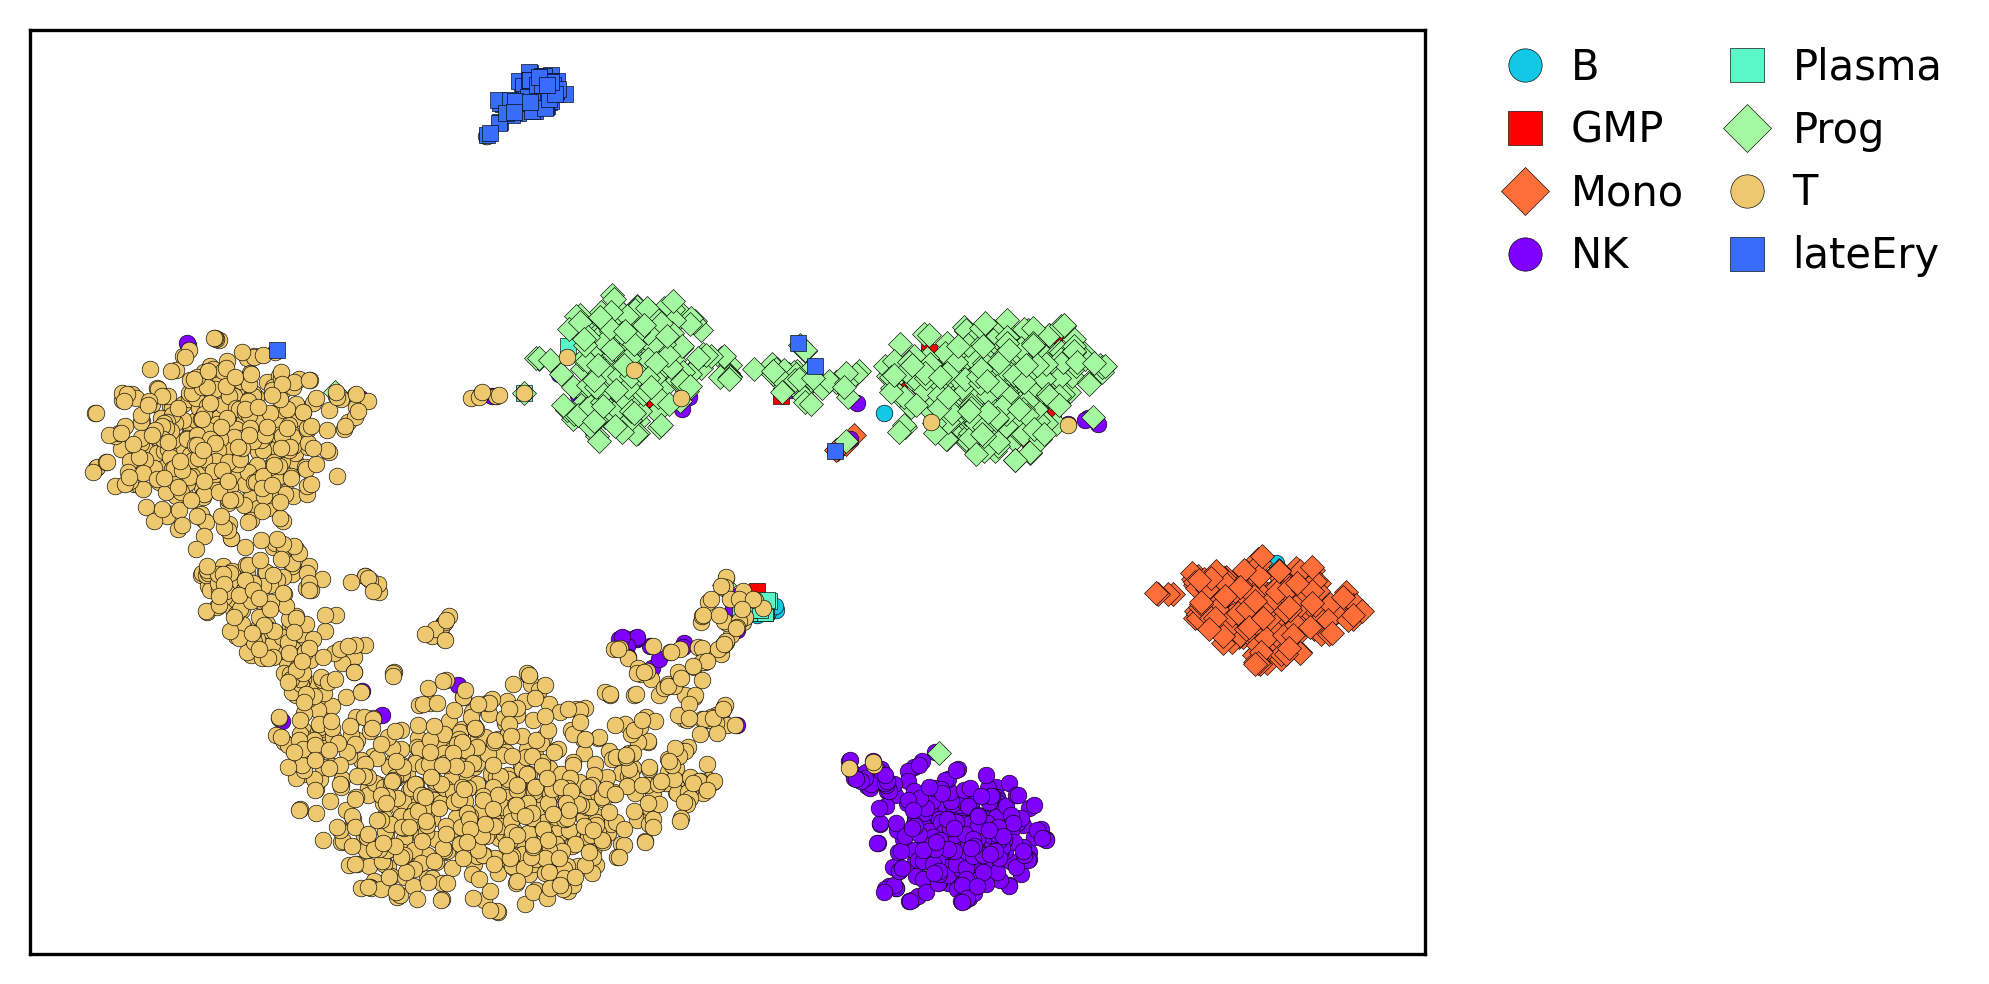

In [123]:
myscatter(ed, cells_number, legend=True)

In [124]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score
def measure(true, pred):
    NMI = round(normalized_mutual_info_score(true, pred), 2)
    RAND = round(adjusted_rand_score(true, pred), 2)
    HOMO = round(homogeneity_score(true, pred), 2)
    COMP = round(completeness_score(true, pred), 2)
    return [NMI, RAND, HOMO, COMP]

In [125]:
labels_new, _,  _ = phenograph.cluster(np.array(h))
measure(cells_number, labels_new)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11880683898925781 seconds


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Jaccard graph constructed in 1.2471632957458496 seconds
Wrote graph to binary file in 0.05909585952758789 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.865942
Louvain completed 21 runs in 4.777036666870117 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.485306262969971 seconds


[0.65, 0.39, 0.85, 0.52]

<Axes: >

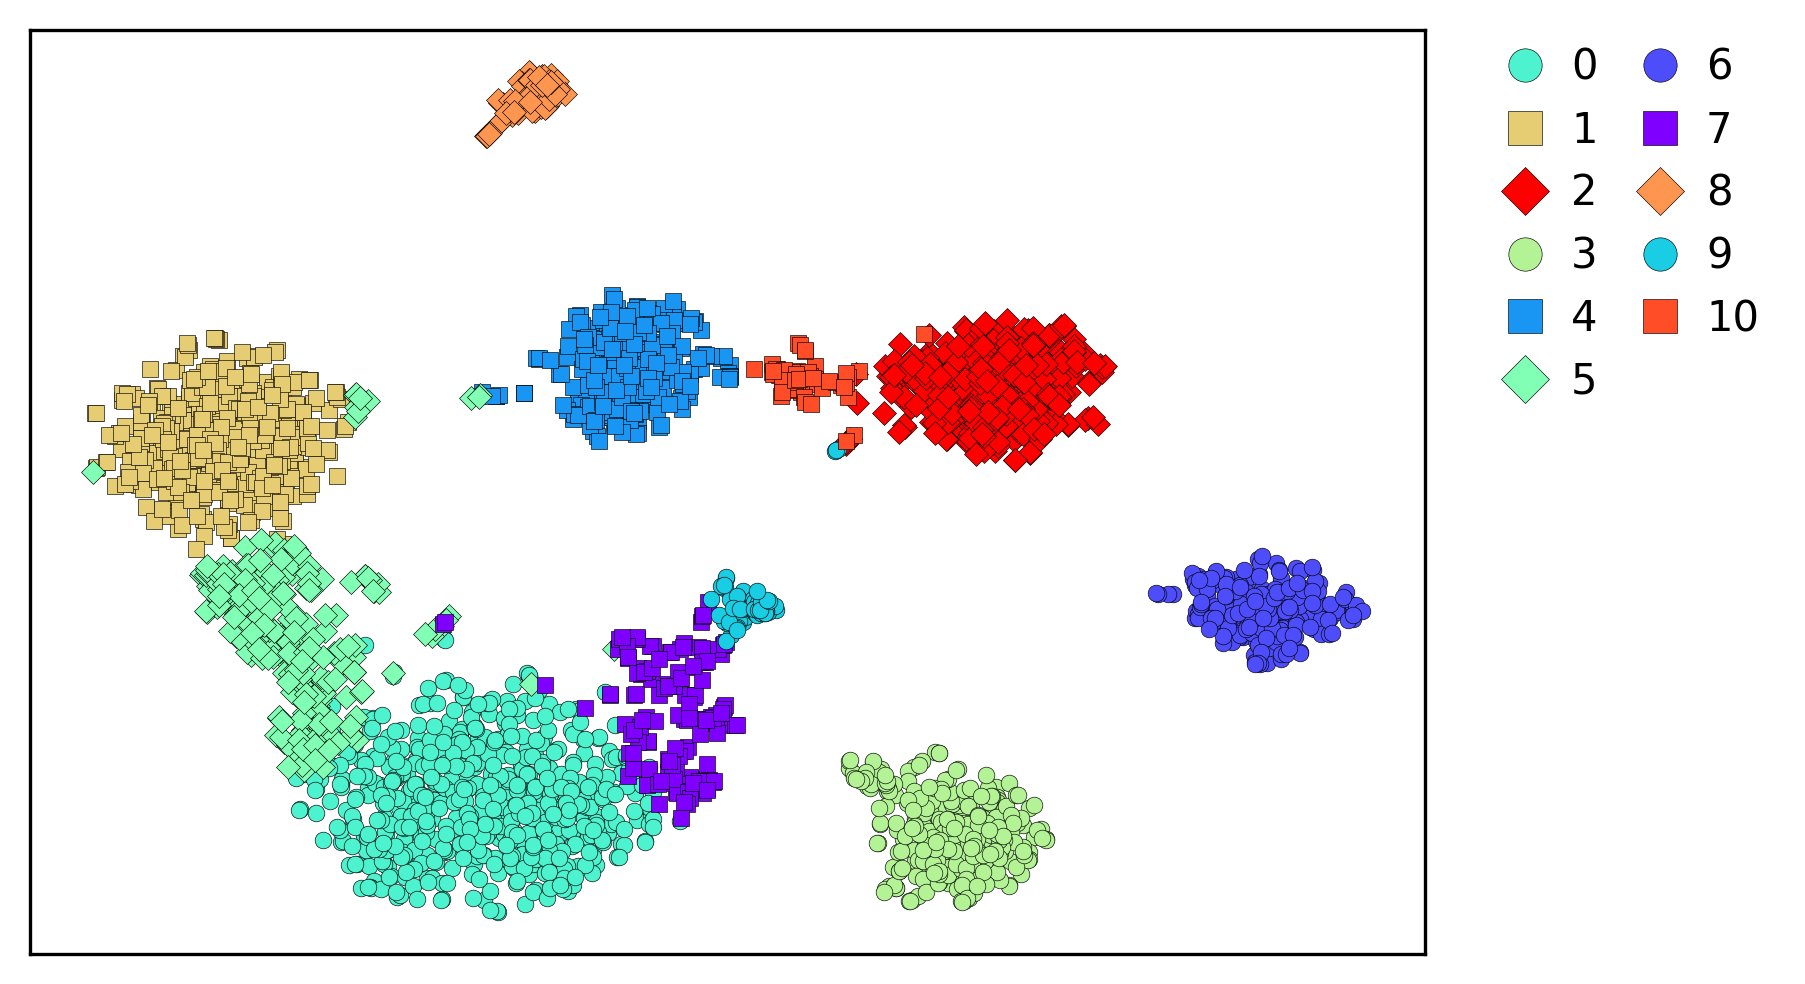

In [126]:
myscatter(ed, labels_new, legend=True)

In [127]:
labels_new = KMeans(n_clusters=10, random_state=0).fit(np.array(h)).labels_
measure(cells_number, labels)

[0.73, 0.58, 0.85, 0.64]

<Axes: >

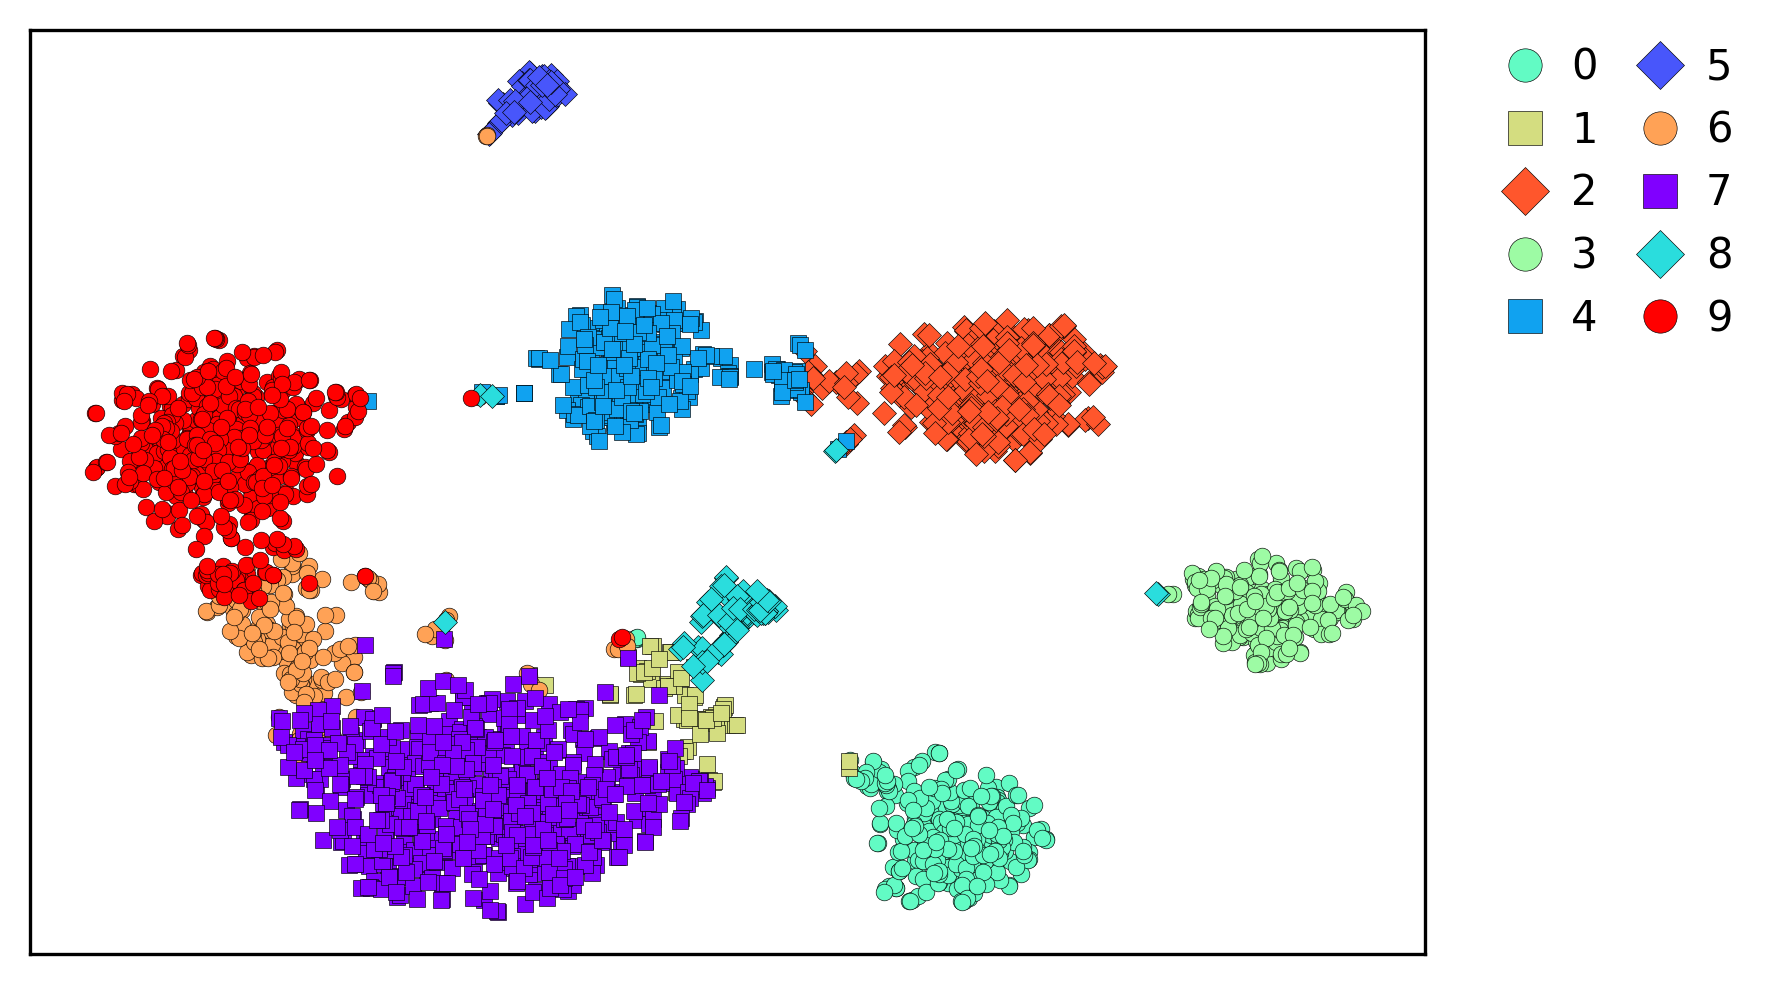

In [128]:
myscatter(ed, labels_new, legend=True)

In [ ]:
save = pd.DataFrame(count)
save.to_csv("/content/drive/My Drive/compbio/test_data/aml328/AML328_norm.csv",index=False,header=True)

In [ ]:
save = pd.DataFrame(cells_number)
save.to_csv("/content/drive/My Drive/compbio/test_data/aml328/AML328_id_norm.csv",index=False,header=True)

In [129]:
save = pd.DataFrame(labels_new)
save.to_csv('/content/drive/My Drive/compbio/AML328_predict_test.csv',index=False,header=True)

In [ ]:
save = pd.DataFrame(np.array(h))
save.to_csv('/content/drive/My Drive/compbio/AML328_RNN_after.csv',index=False,header=True)

In [ ]:
save = pd.DataFrame(ed)
save.to_csv('/content/drive/My Drive/compbio/AML328_RNN_tsne_test.csv',index=False,header=True)